# TASK-5

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.optim
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


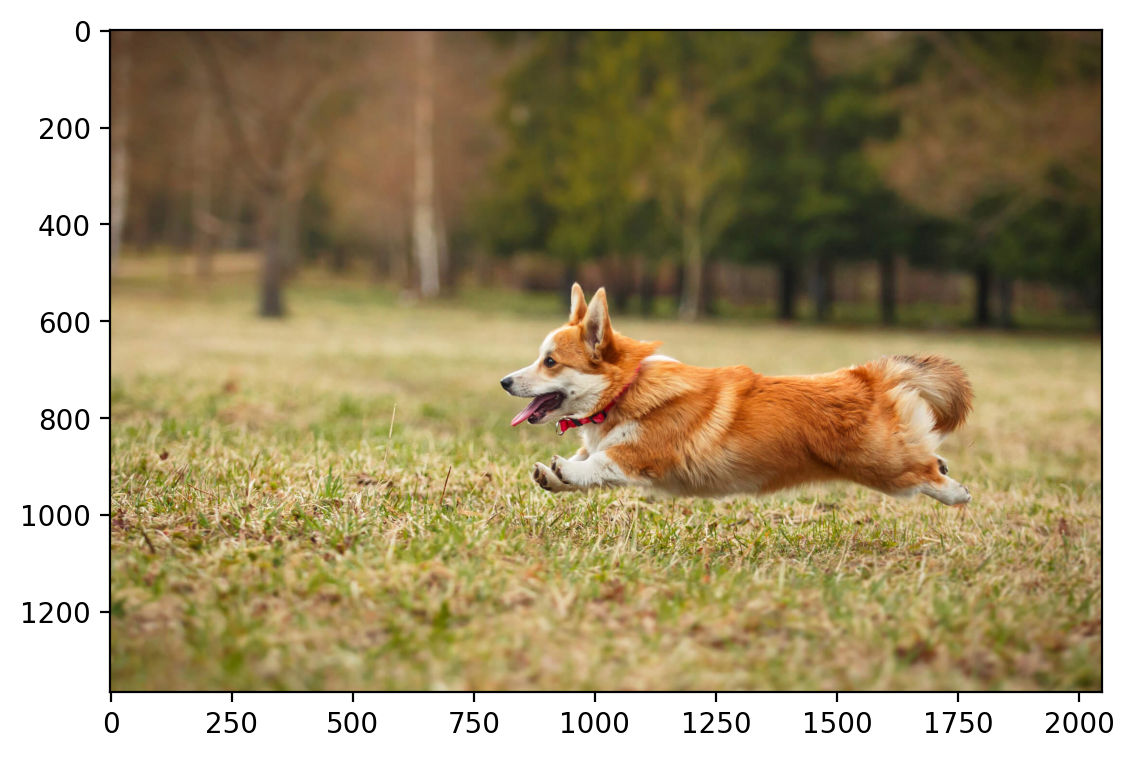

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

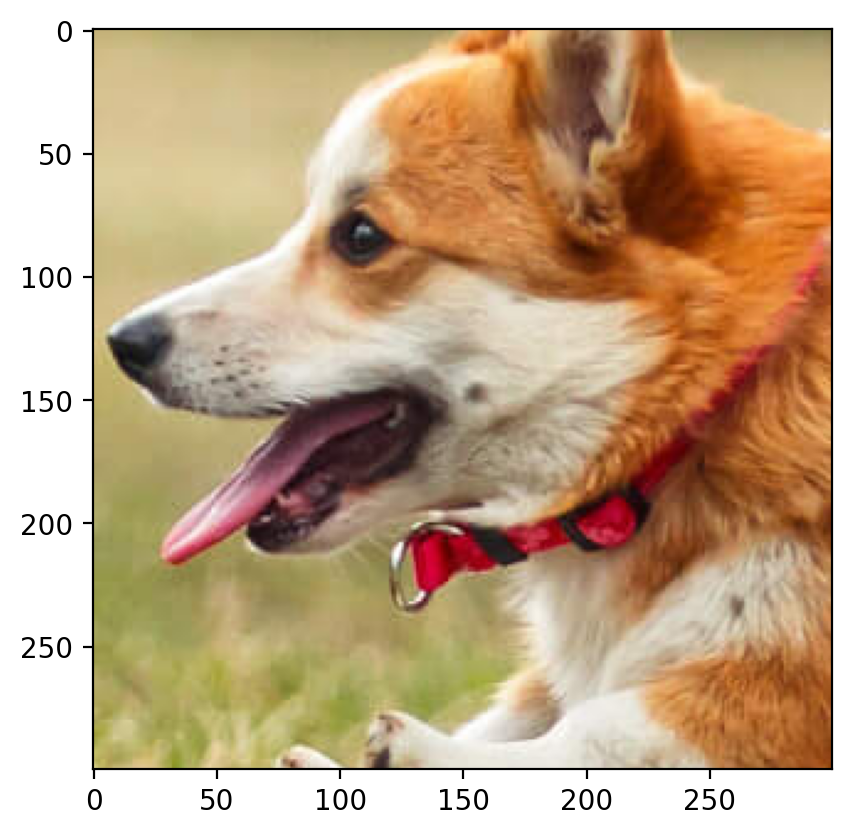

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())

In [ ]:
patch1=torchvision.transforms.functional.crop(crop, 185, 80, 50, 50)

In [ ]:
patch1.shape

torch.Size([3, 50, 50])

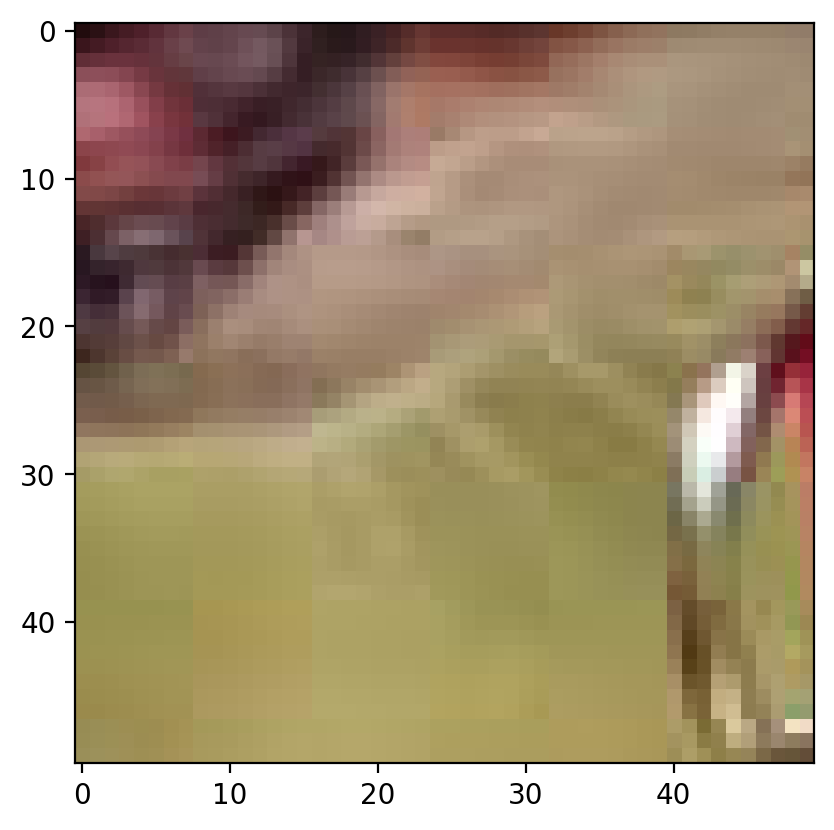

In [ ]:
plt.imshow(rearrange(patch1, 'c h w -> h w c').numpy())

In [ ]:
def factorize(A, k, device=torch.device("cpu")):
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)

    # Train the model
    for i in range(1000):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

In [ ]:
patch1.shape

torch.Size([3, 50, 50])

In [ ]:
patch1=patch1.float()/255

In [ ]:
import math
def compute_rmse_psnr(original, reconstructed):
    """Compute RMSE and PSNR between original and reconstructed image patches."""

    mse = torch.mean((original - reconstructed) ** 2)
    rmse = torch.sqrt(mse).item()

    max_pixel_value = 1.0  #normalized pixel values in the range [0, 1]
    psnr = 20 * math.log10(max_pixel_value / rmse)

    return rmse, psnr



In [ ]:
patch1_hwc=rearrange(patch1, 'c h w -> h w c')

the root mean square error with k=5 is 0.058273833245038986
the peak signal to noise with k=5 is 24.690528262733377


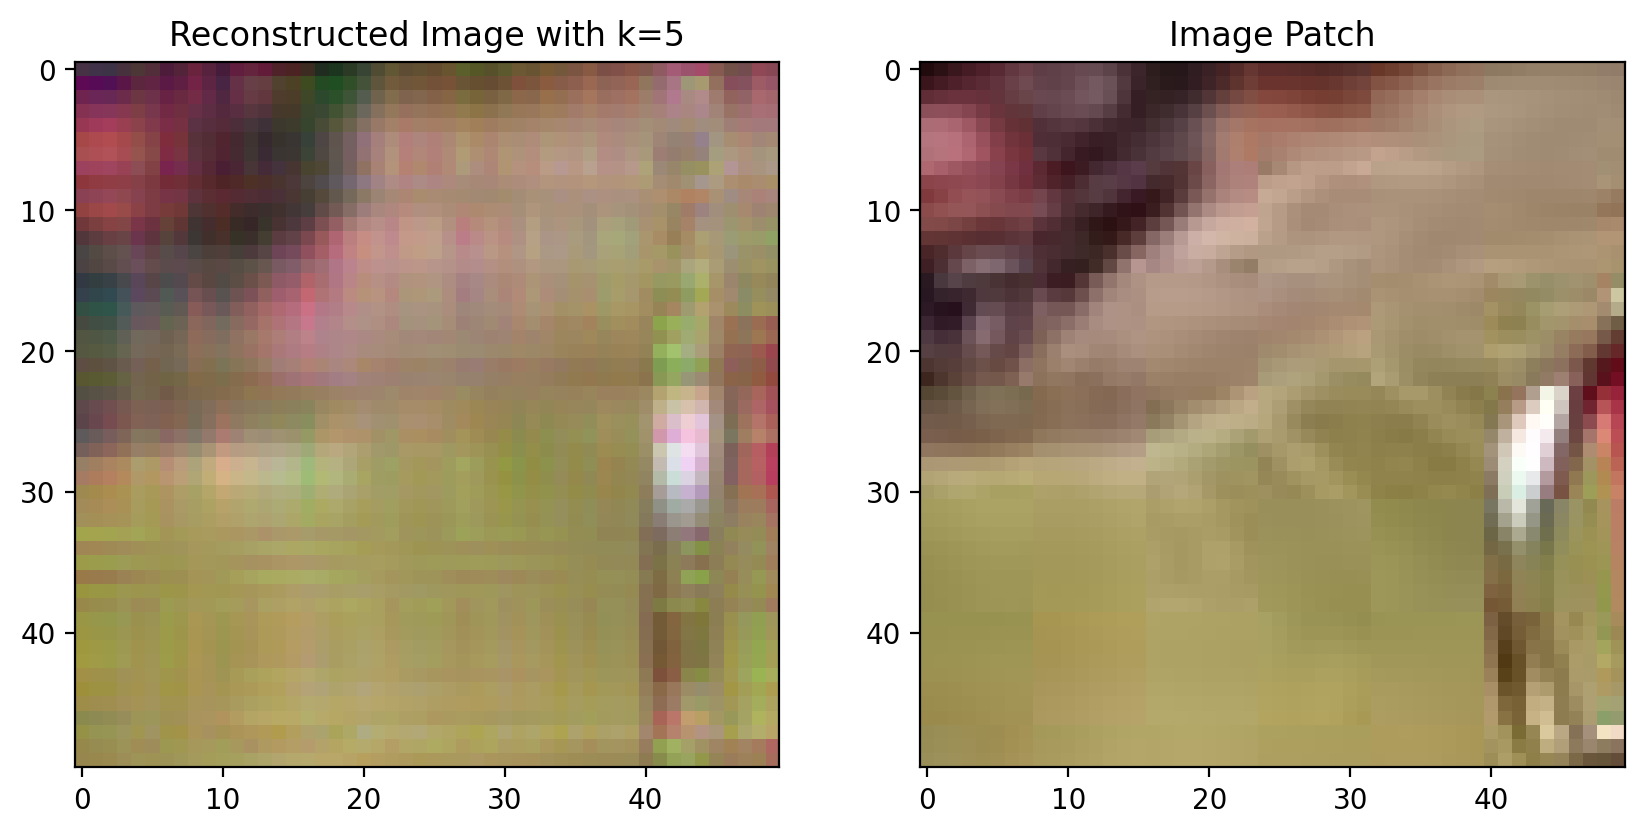

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05360937..1.0222526].


the root mean square error with k=10 is 0.030313849449157715
the peak signal to noise with k=10 is 30.367178212023727


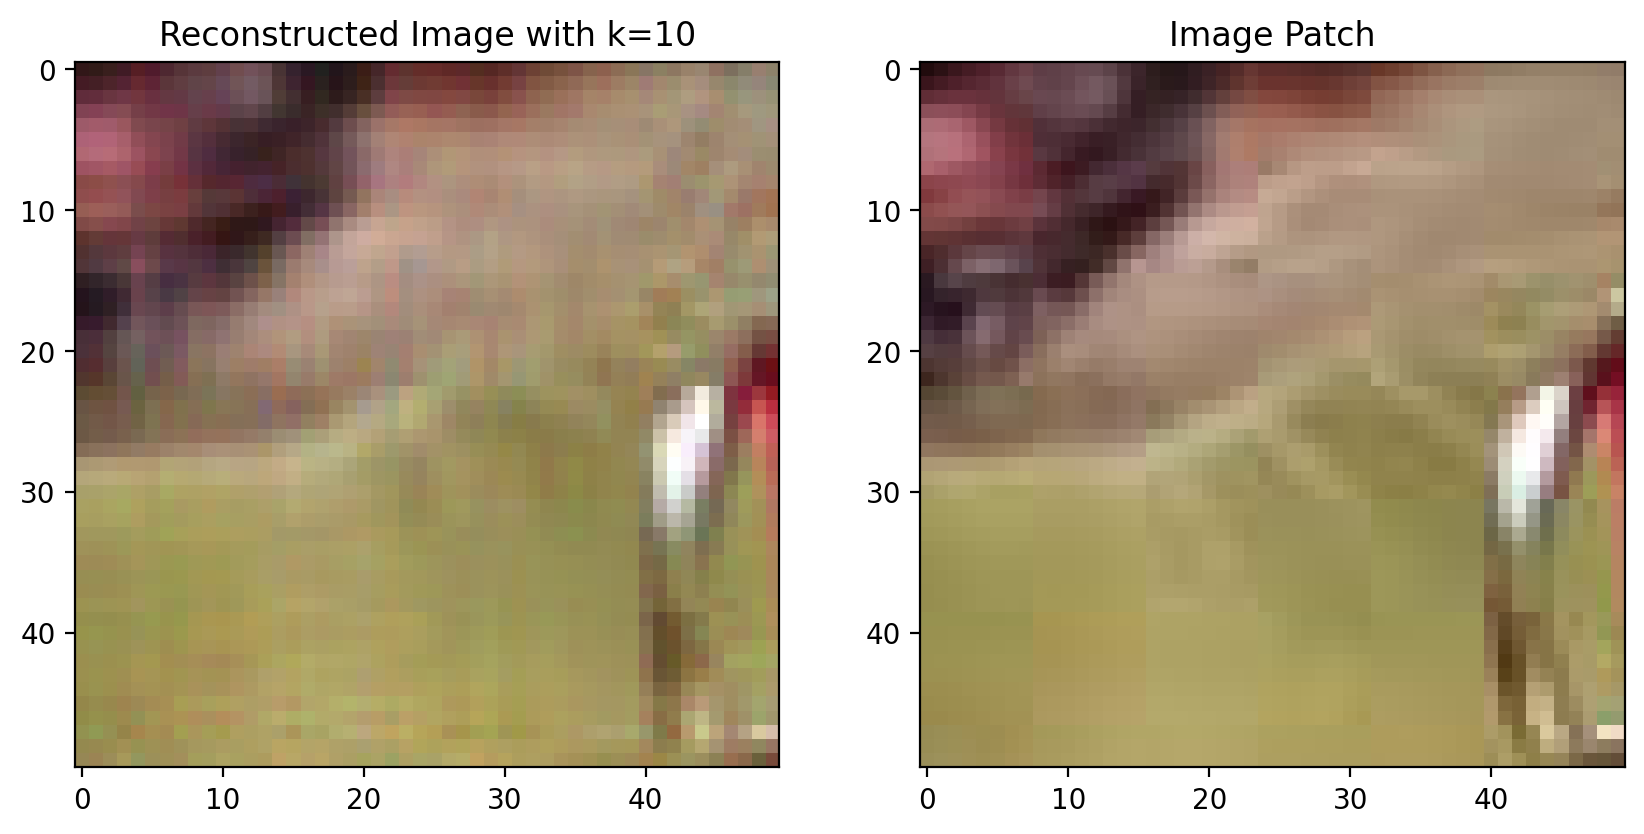

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03815073..1.0128088].


the root mean square error with k=25 is 0.016884729266166687
the peak signal to noise with k=25 is 35.450117971110345


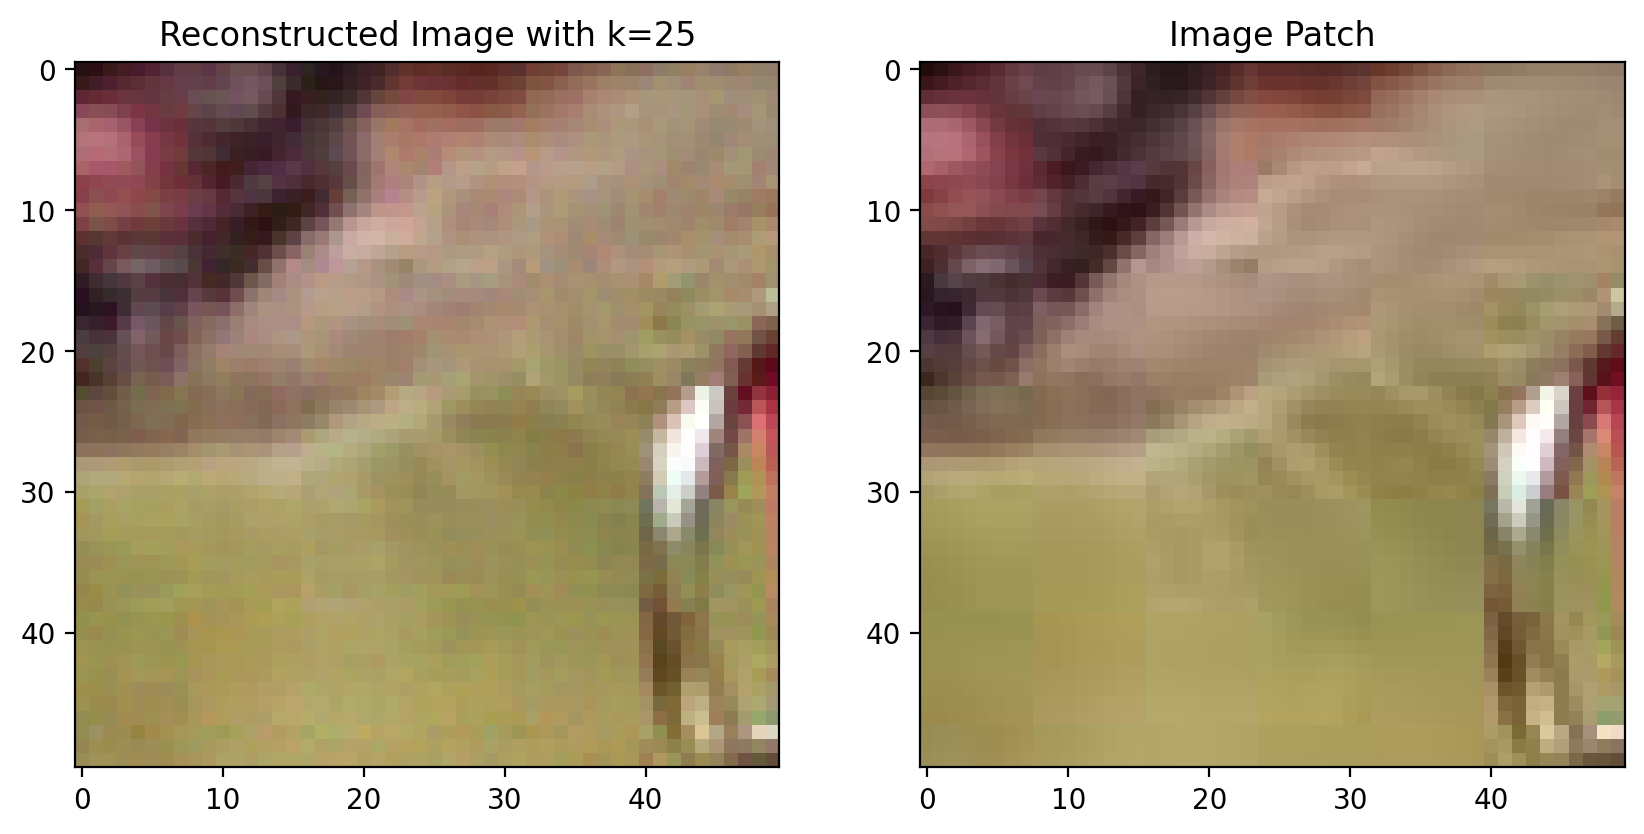

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.043768607..1.019902].


the root mean square error with k=50 is 0.011113167740404606
the peak signal to noise with k=50 is 39.08324260860448


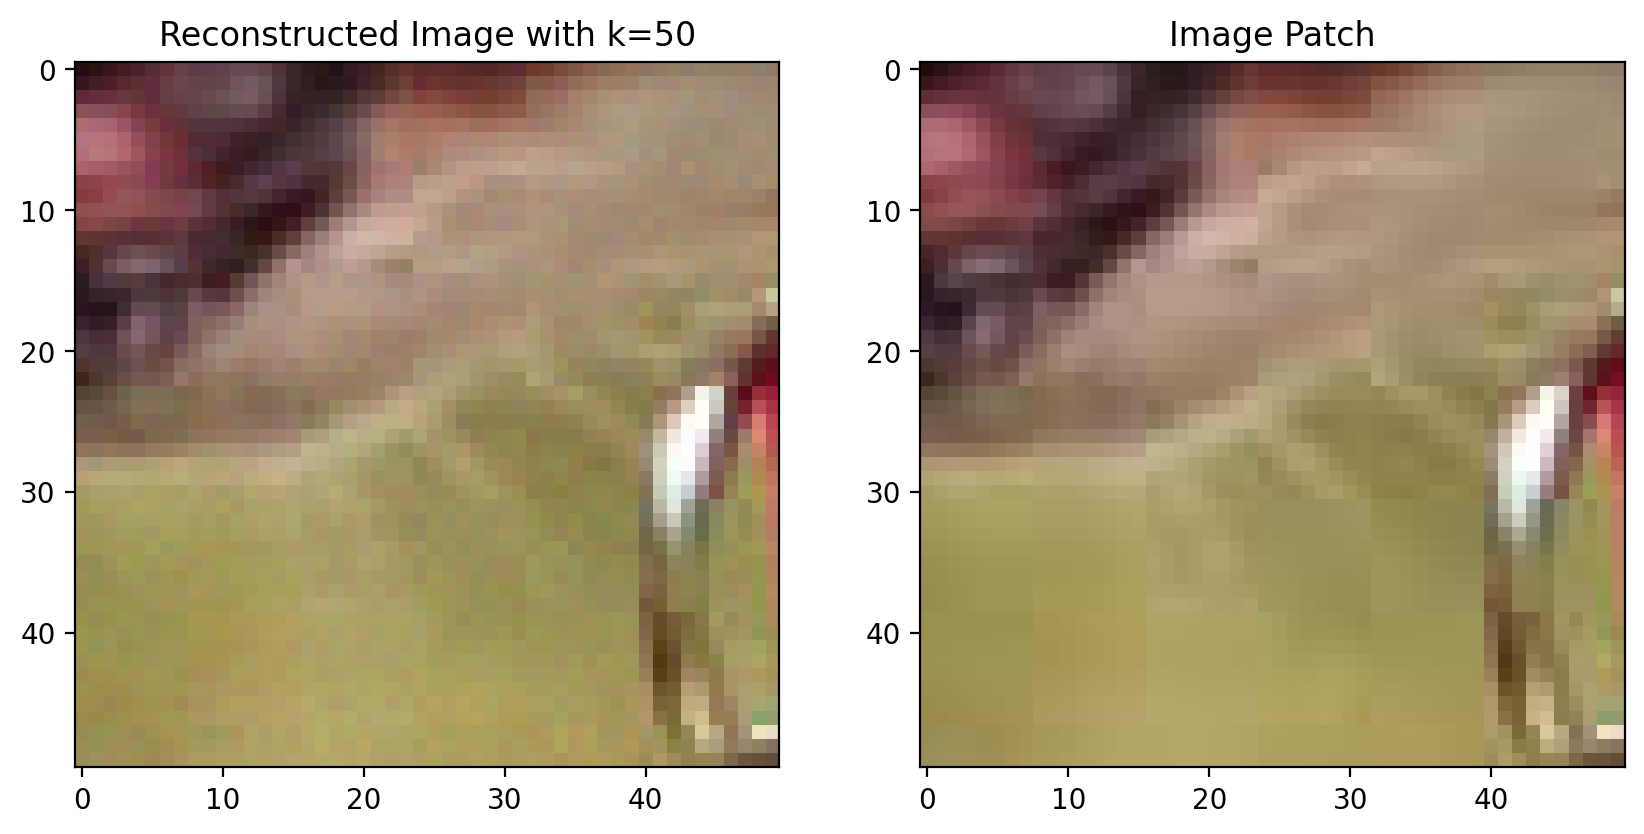

In [ ]:
for i in ([5,10,25,50]):
    W_r, H_r, loss_r = factorize(patch1[0], i, device=device)
    W_g, H_g, loss_g = factorize(patch1[1], i, device=device)
    W_b, H_b, loss_b = factorize(patch1[2], i, device=device)
    reconstructed_r=torch.mm(W_r, H_r)
    reconstructed_g=torch.mm(W_g, H_g)
    reconstructed_b=torch.mm(W_b, H_b)
    reconstructed_rgb = torch.stack([reconstructed_r, reconstructed_g, reconstructed_b], dim=-1)
    reconstructed_rgb_np = reconstructed_rgb.cpu().detach().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the reconstructed image on the left (first subplot)
    axes[0].imshow(reconstructed_rgb_np)
    axes[0].set_title(f"Reconstructed Image with k={i}")
    rmse,psnr=compute_rmse_psnr(patch1_hwc, reconstructed_rgb)
    # Rearrange the patch and display it on the right (second subplot)
    patch1_rearranged = rearrange(patch1, 'c h w -> h w c').numpy()
    axes[1].imshow(patch1_rearranged)
    axes[1].set_title("Image Patch")
    print(f"the root mean square error with k={i} is {rmse}")
    print(f"the peak signal to noise with k={i} is {psnr}")
    # Show the plot
    plt.show()
